# Data downloading and preparation

In [1]:
import pandas as pd
import numpy as np
import json

Let's create dataset in the proper form

In [ ]:
def read_json_file(file_path):
    data_list = []
    with open(file_path, 'r') as file:
        for index, line in enumerate(file):
            try:
                json_object = json.loads(line.strip())
                data_list.append(json_object)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}", index)
    return data_list

# Example usage:
file_path = "./DataLAB4ML/bundle_data.txt" 
dataJSON = read_json_file(file_path)
print(len(dataJSON))

615


In [3]:
save_file = open("./DataLAB4ML/CleanedData.json", "w")  
json.dump(dataJSON, save_file, indent = 6)  
save_file.close()

In [4]:
dataJSON[300]

{'bundle_final_price': '$3.45',
 'bundle_url': 'http://store.steampowered.com/bundle/480/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page',
 'bundle_price': '$6.95',
 'bundle_name': 'Platformer Bundle by New Reality Games',
 'bundle_id': '480',
 'items': [{'genre': 'Action, Adventure, Indie',
   'item_id': '438010',
   'discounted_price': '$0.99',
   'item_url': 'http://store.steampowered.com/app/438010',
   'item_name': 'PulseCharge'},
  {'genre': 'Action, Casual',
   'item_id': '438030',
   'discounted_price': '$0.99',
   'item_url': 'http://store.steampowered.com/app/438030',
   'item_name': 'Dead6hot'},
  {'genre': 'Casual, Indie',
   'item_id': '444480',
   'discounted_price': '$1.99',
   'item_url': 'http://store.steampowered.com/app/444480',
   'item_name': 'Broken Dreams'},
  {'genre': 'Action, Adventure, Indie',
   'item_id': '463220',
   'discounted_price': '$0.99',
   'item_url': 'http://store.steampowered.com/app/463220',
   'item_name': 'Dungeon

From the example of one bundle, we can see that information about item_id, bundle_id and bundle_final_price can be considered relevant in this case, because all other metadata about individual items or bundles can be obtained using these values, so we will not store them in the created dataset.

In [26]:
df = pd.DataFrame(columns=['ItemId', 'BundleId', 'BundleFinalPrice', 'BundleDiscount', 'BundleSize'])
total_item_occurrences = {}

Given that the data is too skewed, it is necessary to add some checks

In [27]:
for bundle in dataJSON:
    bundle_id = bundle['bundle_id']
    bundle_fin_price = bundle['bundle_final_price'].replace('$', '')
    bundle_discount = bundle['bundle_discount'].replace('%', '')
    bundle_size = len(bundle['items'])

    if bundle_id == '' or bundle_fin_price == '':
        continue

    for item in bundle['items']:
        item_id = item['item_id']
        if item_id == '':
            continue

        if ',' in item_id:
            item_id = item_id.split(',')[0]

        if str(item_id) in total_item_occurrences:
            total_item_occurrences[str(item_id)] += 1
        else:
            total_item_occurrences[str(item_id)] = 1
        
        df.loc[len(df.index)] = [item_id, bundle_id, bundle_fin_price, bundle_discount, bundle_size] 


In [28]:
df.dtypes

ItemId              object
BundleId            object
BundleFinalPrice    object
BundleDiscount      object
BundleSize           int64
dtype: object

In [29]:
df = df.astype({
    'ItemId': 'int32',
    'BundleId': 'int32',
    'BundleFinalPrice': 'float',
    'BundleDiscount': 'float',
    'BundleSize': 'int32'
})

In [30]:
df

,ItemId,BundleId,BundleFinalPrice,BundleDiscount,BundleSize
0,326950,450,66.46,10.0,14
1,331490,450,66.46,10.0,14
2,331491,450,66.46,10.0,14
3,331492,450,66.46,10.0,14
4,348540,450,66.46,10.0,14
...,...,...,...,...,...
3510,467220,588,5.58,20.0,2
3511,485090,588,5.58,20.0,2
3512,385230,594,4.77,20.0,3
3513,387880,594,4.77,20.0,3


In [31]:
df.isnull().sum()

ItemId              0
BundleId            0
BundleFinalPrice    0
BundleDiscount      0
BundleSize          0
dtype: int64

# Customize dataset

In [32]:
from surprise import Reader, Dataset, KNNBaseline
from surprise.model_selection import cross_validate

Since the Dataset.load_from_df input needs to be given 3 attributes, which usually denote user_id, item_id, and rating, and user_id and rating are not in the dataset, then we will consider the BundleId column as the values ​​of user_id. 

Since on the Steam platform, where the information for the dataset was taken from, one account cannot buy 1 thing twice,
such a replacement is quite a suitable option. 

As for the rating attribute, it will be generated artificially, based on values ​​such as the total number of purchases of this item in the dataset, the discount received for the bundle that this item is included in, and the average number of items in the bundle that this item is included in. Each of these parameters will have a weight of 0,
3 when calculating the rating value, which will be presented as a natural number with 1 decimal place in the range from 0 to 10. Also, to add naturalness to the rating value, a random value from -1 to 1 will be taken into account, the weight of which in the overall calculation will be 0, 1. 
And therefore, the general formula for calculating the rating for a separate ItemId will be as follows
Rating = (0.3 * BoughtCount) + (0.3 * Discount) + (0.3 * NumItemsInBundle) + (0.1 * Random(-5, 5))

In [35]:
def calculate_custom_rating(row, discount, num_items_in_bundle, weights):
    # Generate random value in range [-5, 5]
    random_value = np.random.uniform(-5, 5)

    # Calculate CustomRating
    custom_rating = float((weights[0] * (total_item_occurrences[str(int(row['ItemId']))])) + (weights[1] * discount) + (weights[2] * num_items_in_bundle) + (weights[3] * random_value))

    return custom_rating

def add_custom_rating_column(df, weights):
    # Calculate CustomRating for each row
    df['CustomRating'] = df.apply(
        lambda row: calculate_custom_rating(row, row['BundleDiscount'], row['BundleSize'], weights),
        axis=1
    )

In [36]:
weights = [0.3, 0.3, 0.3, 0.1]

add_custom_rating_column(df, weights)

In [37]:
def min_max_normalization(data, new_min=0, new_max=1):
    """
    Perform min-max normalization on the input data.

    Parameters:
    - data: A pandas Series or DataFrame column to be normalized.
    - new_min: The minimum value of the new range (default: 0).
    - new_max: The maximum value of the new range (default: 1).

    Returns:
    - normalized_data: The normalized data.
    """
    min_val = data.min()
    max_val = data.max()
    normalized_data = (data - min_val) / (max_val - min_val)  # Formula for min-max normalization
    normalized_data = normalized_data * (new_max - new_min) + new_min  # Scale to new range

    # Round to one decimal place
    normalized_data = normalized_data.round(1)
    return normalized_data

In [38]:
df['CustomRating'] = min_max_normalization(df['CustomRating'], 0, 10)

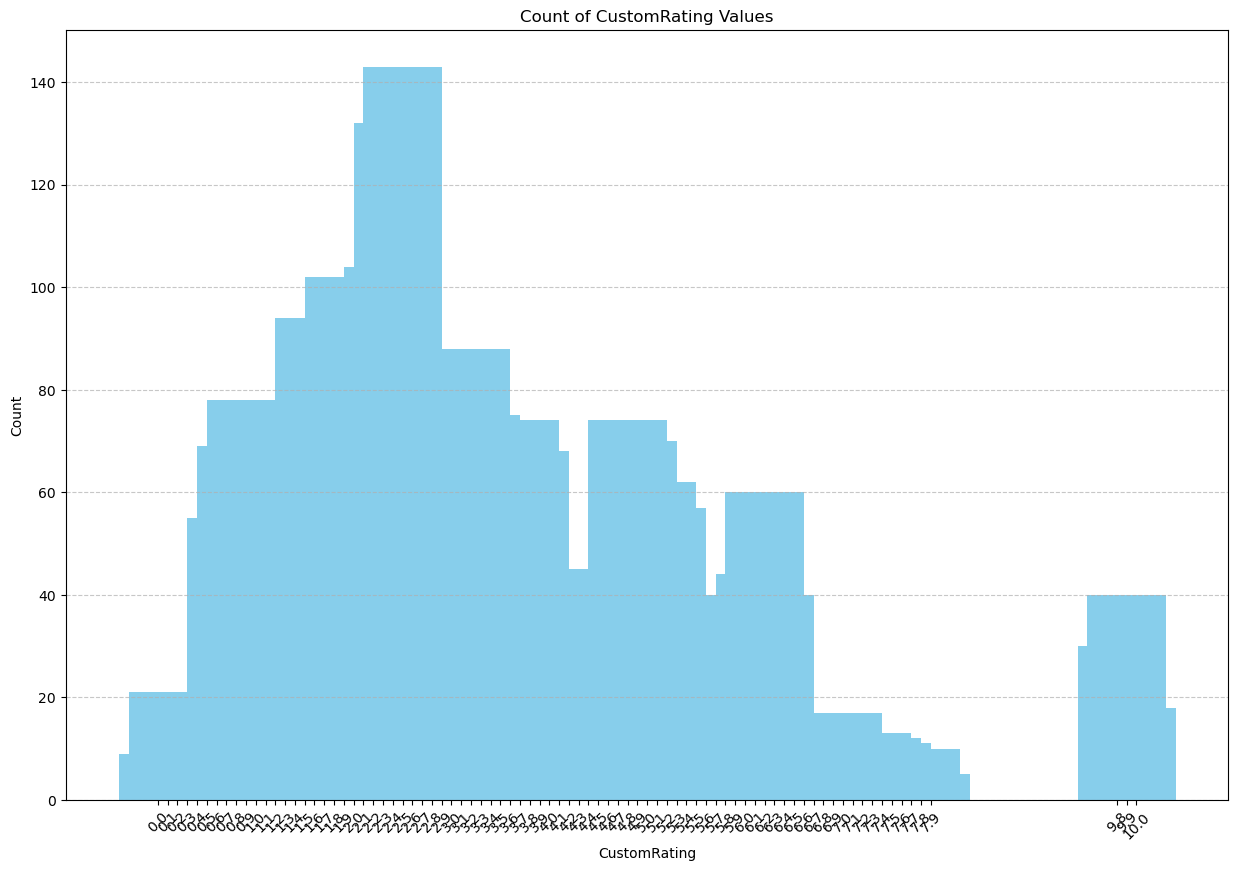

In [39]:
import matplotlib.pyplot as plt


value_counts = df['CustomRating'].value_counts().sort_index()

# Plot the value counts
plt.figure(figsize=(15, 10))
plt.bar(value_counts.index, value_counts.values, color='skyblue')
plt.xlabel('CustomRating')
plt.ylabel('Count')
plt.title('Count of CustomRating Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(value_counts.index, rotation=45)
plt.show()

# Implementing a recommendation system

In this implementation, a decision was made to create a recommendation system based on the similarity of bundles and the things that make up these bundles.

In [95]:
# Define the rating scale based on BundleFinalPrice (min and max values)
min_rating = df['CustomRating'].min()
max_rating = df['CustomRating'].max()
reader = Reader(rating_scale=(min_rating, max_rating))

data_surprise = Dataset.load_from_df(df[['BundleId', 'ItemId', 'CustomRating']], reader)

# Define a cross-validation scheme
cv = 10  # Number of folds for cross-validation

Let's find the best parameters

In [96]:
from surprise.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'k': [10, 20, 30, 40], 
              'min_k': [1, 2, 3, 4]}  

# Initialize GridSearchCV
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=10)

# Fit GridSearchCV to the data
gs.fit(data_surprise)

# Get best RMSE and MAE scores
print('Best RMSE score:', gs.best_score['rmse'])
print('Best MAE score:', gs.best_score['mae'])
print('Best parameters:', gs.best_params['rmse'])

best_k = gs.best_params['rmse']['k']
best_min_k = gs.best_params['rmse']['min_k']

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [97]:
from surprise.model_selection import train_test_split

In [98]:
# Split the data into train and test sets
trainset, testset = train_test_split(data_surprise, test_size=0.2)

algo = KNNBaseline(verbose=False, k=best_k, min_k=best_min_k)

history = algo.fit(trainset)

In [99]:
from math import fabs

def make_recommendations():
    # Make predictions on the testset
    predictions = algo.test(testset)

    results_df = pd.DataFrame(columns=['BundleId', 'ItemId', 'ActualRating', 'EstimatedRating', 'AERating']) # AE means absolute error
    # Example of printing predictions
    for pred in predictions:
        if not pred[4]['was_impossible']:
            bundle_id, item_id, act_rating, est_rating = int(pred[0]), int(pred[1]), float(pred[2]), float(pred[3])
            ae_rating = float(fabs(act_rating - est_rating))

            results_df.loc[len(results_df.index)] = [bundle_id, item_id, act_rating, est_rating, ae_rating] 
            print(pred)
        else:
            print('Single prediction can`t be made')
    return results_df

In [100]:
res_df = make_recommendations()

user: 383        item: 31280      r_ui = 5.70   est = 5.03   {'was_impossible': False}
user: 1103       item: 489910     r_ui = 1.00   est = 0.94   {'actual_k': 1, 'was_impossible': False}
user: 1246       item: 7110       r_ui = 1.50   est = 3.02   {'was_impossible': False}
user: 264        item: 271590     r_ui = 0.90   est = 2.91   {'was_impossible': False}
user: 376        item: 362870     r_ui = 1.00   est = 2.94   {'was_impossible': False}
user: 809        item: 359490     r_ui = 1.10   est = 1.99   {'actual_k': 1, 'was_impossible': False}
user: 1407       item: 331710     r_ui = 4.50   est = 3.88   {'was_impossible': False}
user: 382        item: 296970     r_ui = 0.60   est = 3.13   {'was_impossible': False}
user: 693        item: 455250     r_ui = 1.60   est = 3.10   {'was_impossible': False}
user: 1034       item: 342620     r_ui = 1.70   est = 3.10   {'was_impossible': False}
user: 1225       item: 520900     r_ui = 0.50   est = 3.28   {'was_impossible': False}
user: 331    

In [101]:
res_df = res_df.astype({
    'BundleId': 'int32',
    'ItemId': 'int32'
})

In [102]:
res_df

,BundleId,ItemId,ActualRating,EstimatedRating,AERating
0,383,31280,5.7,5.025862,0.674138
1,1103,489910,1.0,0.941346,0.058654
2,1246,7110,1.5,3.019672,1.519672
3,264,271590,0.9,2.907457,2.007457
4,376,362870,1.0,2.942749,1.942749
...,...,...,...,...,...
698,1183,383100,3.2,3.262615,0.062615
699,383,31230,5.8,5.025862,0.774138
700,1046,488010,2.2,3.036447,0.836447
701,1421,525832,2.4,3.011576,0.611576


# Validate the implemented system

Let's validate the implemented system (RMSE and MAE metrics). After analyzing 10 cases when the system makes the most mistakes and 10 cases when the system makes correct predictions with an error close to 0, let's draw conclusions about what is lacking in the built recommender system

In [103]:
# Perform cross-validation
results = cross_validate(algo, data_surprise, measures=['RMSE', 'MAE'], cv=cv, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    1.1944  1.1908  1.0909  1.1780  1.2599  1.1957  1.1706  1.1972  1.1407  1.2058  1.1824  0.0418  
MAE (testset)     0.9492  0.9588  0.8448  0.9276  1.0109  0.9317  0.9318  0.9527  0.9323  0.9536  0.9393  0.0390  
Fit time          0.02    0.01    0.01    0.02    0.01    0.01    0.02    0.01    0.01    0.01    0.01    0.00    
Test time         0.00    0.01    0.00    0.00    0.00    0.00    0.00    0.01    0.00    0.00    0.00    0.00    


Let's look at the 10 best and worst absolute error values ​​between expected and actual rating values

In [93]:
lowest_aerating = res_df.nsmallest(10, 'AERating')
highest_aerating = res_df.nlargest(10, 'AERating')

print("10 rows with the lowest AERating:")
print(lowest_aerating)

print("\n10 rows with the highest AERating:")
print(highest_aerating)


10 rows with the lowest AERating:
    BundleId  ItemId  ActualRating  EstimatedRating  AERating
1        663   11390           3.9              3.9       0.0
3        413  242860           0.8              0.8       0.0
4       1028  394220           3.1              3.1       0.0
5        531  302320           3.7              3.7       0.0
6       1264  516980           2.4              2.4       0.0
10       914  259592           2.4              2.4       0.0
11       701  464520           3.3              3.3       0.0
13       663  315260           3.7              3.7       0.0
14      1190  381712           6.9              6.9       0.0
17      1247   47930           3.0              3.0       0.0

10 rows with the highest AERating:
     BundleId  ItemId  ActualRating  EstimatedRating  AERating
122      1399   45740           1.5         4.258032  2.758032
244      1373  383270           0.5         3.105350  2.605350
298       574    3910           0.2         2.682293  2.482

Let's review the situation for an individual user/bundle

In [94]:
res_df.loc[res_df['BundleId'] == 833]

,BundleId,ItemId,ActualRating,EstimatedRating,AERating
292,833,473470,6.4,4.300829,2.099171
591,833,448640,6.6,6.615511,0.015511


We have error assessment results close to zero, as well as those that are not too far from the ideal value. Considering the fact that the rating values ​​were created artificially, although they are close to a normal distribution, and therefore reach a relative level of naturalness, the system has too little dataset,
to learn to make MORE predictions with less error. As you can see, many predictions do not have the 'actual_k' parameter in the predicted, which means that no real "neighbors" were found to perform the prediction

# Achieve improvement

Lets' achieve improvement of basic metrics.

In [104]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df1 = df.copy()

df1['CustomRating'] = scaler.fit_transform(df1[['CustomRating']])
df1.head(15)

,ItemId,BundleId,BundleFinalPrice,BundleDiscount,BundleSize,CustomRating
0,326950,450,66.46,10.0,14,0.17
1,331490,450,66.46,10.0,14,0.17
2,331491,450,66.46,10.0,14,0.16
3,331492,450,66.46,10.0,14,0.16
4,348540,450,66.46,10.0,14,0.17
5,352010,450,66.46,10.0,14,0.17
6,390470,450,66.46,10.0,14,0.16
7,394050,450,66.46,10.0,14,0.17
8,398100,450,66.46,10.0,14,0.16
9,408770,450,66.46,10.0,14,0.17


In [107]:
# Define the rating scale based on BundleFinalPrice (min and max values)
min_rating = df1['CustomRating'].min()
max_rating = df1['CustomRating'].max()
reader = Reader(rating_scale=(min_rating, max_rating))

data_surprise = Dataset.load_from_df(df1[['BundleId', 'ItemId', 'CustomRating']], reader)

# Define a cross-validation scheme
cv = 10  # Number of folds for cross-validation

In [110]:
# Define parameter grid
param_grid = {
    'k': [10, 20, 30, 40], 
    'min_k': [1, 2, 3, 4],
    'sim_options': {
        'name': ['MSD', 'pearson_baseline'],
        'user_based': [True, False] 
    }
}  

# Initialize GridSearchCV
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=10)

# Fit GridSearchCV to the data
gs.fit(data_surprise)

# Get best RMSE and MAE scores
print('Best RMSE score:', gs.best_score['rmse'])
print('Best MAE score:', gs.best_score['mae'])
print('Best parameters:', gs.best_params['rmse'])
print(gs)

best_k = gs.best_params['rmse']['k']
best_min_k = gs.best_params['rmse']['min_k']

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [112]:
algo = KNNBaseline(verbose=False, k=best_k, min_k=best_min_k, sim_options={'user_based': False})
results = cross_validate(algo, data_surprise, measures=['RMSE', 'MAE'], cv=cv, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.1027  0.0968  0.1002  0.1045  0.1004  0.1018  0.1064  0.1076  0.0990  0.1078  0.1027  0.0036  
MAE (testset)     0.0729  0.0677  0.0722  0.0720  0.0701  0.0715  0.0744  0.0758  0.0670  0.0767  0.0720  0.0030  
Fit time          0.21    0.19    0.07    0.12    0.08    0.06    0.07    0.06    0.06    0.06    0.10    0.06    
Test time         0.00    0.01    0.01    0.01    0.00    0.01    0.00    0.01    0.00    0.01    0.01    0.00    


As we can see, by normalizing the rating values, the RMSE and MAE metrics have improved many times.

# Experiments

For comparison, let's calculate the accuracy of recommendations of a random system (when recommendations are random/median/average)

In [113]:
df1['RandomRating'] = np.random.uniform(0, 1, size=len(df))

In [123]:
df1['MeanRating'] = np.full(df1['CustomRating'].shape, df1['CustomRating'].mean())

In [124]:
df1['MedianRating'] = np.full(df1['CustomRating'].shape, df1['CustomRating'].median())

In [125]:
df1

,ItemId,BundleId,BundleFinalPrice,BundleDiscount,BundleSize,CustomRating,RandomRating,MeanRating,MedianRating
0,326950,450,66.46,10.0,14,0.17,0.358418,0.326347,0.28
1,331490,450,66.46,10.0,14,0.17,0.200969,0.326347,0.28
2,331491,450,66.46,10.0,14,0.16,0.477417,0.326347,0.28
3,331492,450,66.46,10.0,14,0.16,0.898563,0.326347,0.28
4,348540,450,66.46,10.0,14,0.17,0.611505,0.326347,0.28
...,...,...,...,...,...,...,...,...,...
3510,467220,588,5.58,20.0,2,0.20,0.126394,0.326347,0.28
3511,485090,588,5.58,20.0,2,0.14,0.606964,0.326347,0.28
3512,385230,594,4.77,20.0,3,0.16,0.134688,0.326347,0.28
3513,387880,594,4.77,20.0,3,0.15,0.758908,0.326347,0.28


In [127]:
from sklearn.metrics import mean_absolute_error

def calculate_rmse(column1, column2):
    squared_diff = (column1 - column2) ** 2

    # Calculate the mean of the squared differences
    mean_squared_diff = squared_diff.mean()

    # Take the square root of the mean squared differences
    rmse = np.sqrt(mean_squared_diff)

    return rmse

In [128]:
print(f"RMSE for random values: {calculate_rmse(df1['CustomRating'], df1['RandomRating'])}")
print(f"MAE for random values: {mean_absolute_error(df1['CustomRating'], df1['RandomRating'])}")

RMSE for random values: 0.39596195406642914
MAE for random values: 0.32416795514967917


In [129]:
print(f"RMSE for mean values: {calculate_rmse(df1['CustomRating'], df1['MeanRating'])}")
print(f"MAE for mean values: {mean_absolute_error(df1['CustomRating'], df1['MeanRating'])}")

RMSE for mean values: 0.2035995403902359
MAE for mean values: 0.16065772497060962


In [130]:
print(f"RMSE for median values: {calculate_rmse(df1['CustomRating'], df1['MedianRating'])}")
print(f"MAE for median values: {mean_absolute_error(df1['CustomRating'], df1['MedianRating'])}")

RMSE for median values: 0.20880810577073364
MAE for median values: 0.156873399715505


From the results of the metrics for all the generated ratings, we can see that the original one gives the best results

# Conclusions

In this notebook, the recommendation model algorithm was implemented based on KNNBaseline using the Surprise library. For this, a given dataset containing information about various bundles and their attributes was used.
The structure of the dataset and the characteristics of the algorithm were studied.
The implemented recommender system is based on this dataset and algorithm, and was cross-validated.
In the process of analyzing the results, it was found that the system makes the most mistakes on subjects with a small number of similar users or subjects in the training data set.
Some items have a large number of similar users, which contributes to more accurate recommendations.
To improve the accuracy of the model, hyperparametric tuning was performed using GridSearchCV and ranking normalization, which allowed to reduce the values ​​of the RMSE and MAE metrics. Compared to a random recommender system,
the system based on KNNBaseline showed significantly better results, highlighting the importance of using specialized algorithms for the recommendation task.